In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib

In [2]:
input_parameters = [
    'Mass', 
    'Radius',
    'H2O_mass_frac', 
]

output_parameters = [
    'H2O_radial_frac',
    'Core_radial_frac',
    'Core_mass_frac',
    'P_CMB', 
    'T_CMB',
]
# load trained model and scaler
OUTPUT_DIMS = 5
N_MIXES = 20
model = load_model(
    "RockyExop_MDN.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("MDN_INPUT_scaler.save")
output_scaler = joblib.load("MDN_OUTPUT_scaler.save")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Predict Earth (for example)

In [3]:
# EARTH
# input mass and radius for predicting must be earth units
input_array_earth = np.array(
    [
        [1], # mass
        [1], # radius
        [0.001], # water mass fraction
    ]
)
scaled_input = input_scaler.transform(input_array_earth.T)

In [5]:
pred = model.predict(scaled_input)
# pred contains parameters for distributions, not actual points on the graph.
print(pred)
print(pred.shape)

[[ 2.01693643e-02  8.71409178e-01  7.70799935e-01  6.97955564e-02
   2.18540549e-01  5.88760674e-02  6.96225822e-01  5.92369735e-01
   5.21097854e-02  1.51286960e-01 -7.02783093e-03  7.09326327e-01
   3.94753039e-01  4.67918515e-02  1.99384809e-01  2.04770118e-02
   8.47895145e-01  7.12566316e-01  4.76715863e-02  1.91341907e-01
   2.38194764e-02  5.50590396e-01  2.43836462e-01  6.77525923e-02
   2.15391517e-01  1.96241494e-02  7.07450151e-01  4.56832886e-01
   6.89911172e-02  2.08974004e-01  7.81297162e-02  2.86597371e-01
   2.20053196e-01  1.51609331e-02  1.11362010e-01  2.22667325e-02
   8.86226654e-01  8.03274214e-01  1.43116668e-01  3.24237376e-01
   2.99830586e-02  7.59322047e-01  5.48856556e-01  8.25497508e-02
   2.32849553e-01  8.69666319e-03  8.26479435e-01  6.75667763e-01
   5.61417937e-02  2.30564594e-01  1.52686238e-02  7.81718731e-01
   5.81416547e-01  3.17503363e-02  1.47385895e-01  2.37682983e-02
   7.63546109e-01  5.30838788e-01  6.01350665e-02  2.43867278e-01
   1.63040

In [6]:
# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(5):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
    print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*5 + m])
        locals()['sigs'+str(m)].append(sigs[0][n*5 + m])

0
1
2
3
4


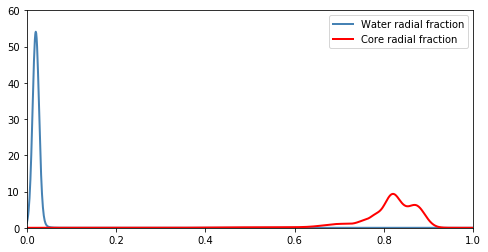

In [7]:
# plot the predited distributions for the scaled parameters of the earth


colors = [
    "steelblue",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
predict_label = [
    "Water radial fraction", 
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure", 
    "CMB temperature"
]

fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(0,1,0.001).reshape(-1,1)
for i, label in zip(range(2), predict_label[:2]):
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((x-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # Sum multiple Gaussian distributions
    plt.plot(x, GMM_PDF, color=colors[i], label=label, lw=2)
plt.legend()
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.xlim(0,1)
plt.ylim(0,60)
plt.show()

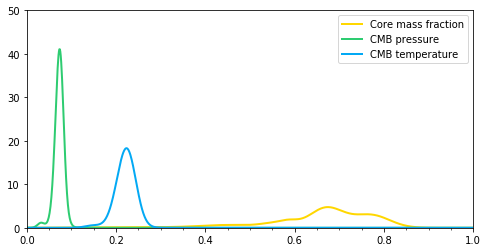

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
for i, label in zip(range(3), predict_label[2:]):
    i += 2
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((x-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        x, 
        GMM_PDF, 
        color=colors[i], 
        label=label, 
        lw=2
    )
plt.legend()
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
plt.xlim(0,1)
plt.ylim(0,50)
plt.show()